Correlation with playResult:
playResult                     1.000000
offenseFormation_I_FORM        0.407478
receiverAlignment_2x1          0.384195
presnap_score_difference       0.282033
offenseFormation_SINGLEBACK    0.227010
shiftSinceLineset              0.217943
offenseFormation_PISTOL        0.144669
offenseFormation_JUMBO         0.108878
receiverAlignment_1x1          0.076817
gameClock_seconds              0.063792
receiverAlignment_2x2          0.012063
receiverAlignment_4x1         -0.057986
receiverAlignment_3x1         -0.172361
receiverAlignment_3x2         -0.270576
offenseFormation_EMPTY        -0.278012
motionSinceLineset            -0.286902
down_yardsToGo                -0.348579
offenseFormation_SHOTGUN      -0.379380
Name: playResult, dtype: float64
Training model...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits

Training time: 1144.25 seconds

Best parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__max_feature

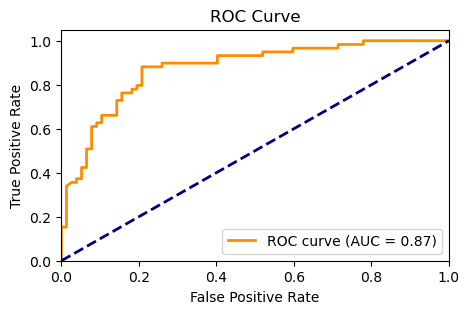


Feature Ranking Based on SHAP Values (Grouped):
1. offenseFormation (0.1776)
2. motionSinceLineset (0.1224)
3. receiverAlignment (0.0881)
4. presnap_score_difference (0.0379)
5. down_yardsToGo (0.0354)
6. gameClock_seconds (0.0204)
7. shiftSinceLineset (0.0200)


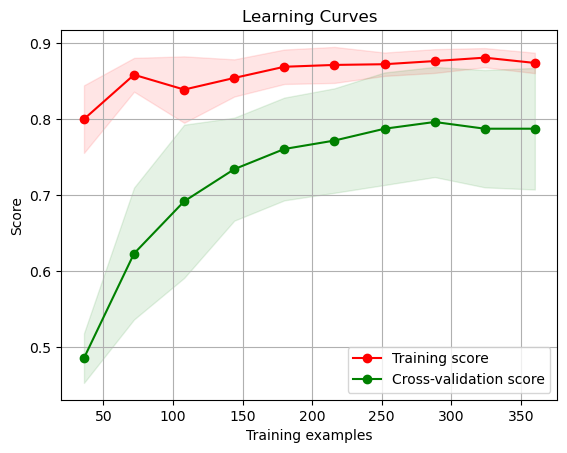

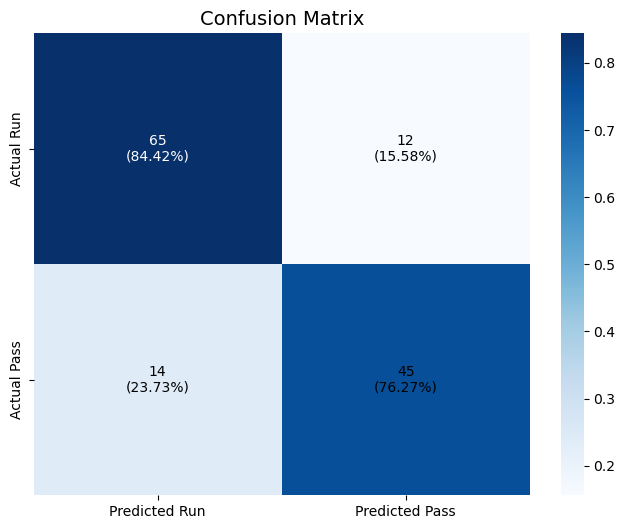

In [3]:
#Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import time
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import KNNImputer
import os

BASE_DIR = os.path.dirname(os.path.abspath(__file__))
DATA_DIR = os.path.join(BASE_DIR, 'data') 

# File paths
plays_file = os.path.join(DATA_DIR, 'plays.csv')
games_file = os.path.join(DATA_DIR, 'games.csv')
player_play_file = os.path.join(DATA_DIR, 'player_play.csv')
players_file = os.path.join(DATA_DIR, 'players.csv')

# Data Import
plays_columns = ['gameId', 'playId', 'passResult', 'offenseFormation', 'down', 'yardsToGo', 'receiverAlignment',
                 'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore']
plays_data = pd.read_csv(plays_file, usecols=plays_columns)
games_data = pd.read_csv(games_file)
player_play_data = pd.read_csv(player_play_file, usecols=['nflId', 'gameId', 'playId',
                                                          'teamAbbr', 'hadRushAttempt', 'shiftSinceLineset', 'motionSinceLineset'])
players_data = pd.read_csv(players_file)
teams_data = games_data[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']]

# Data Merging
player_play_merged = player_play_data.merge(players_data[['nflId', 'position']], on='nflId', how='left')
play_game_merged = player_play_merged.merge(plays_data, on=['gameId', 'playId'], how='left')
master_data = play_game_merged.merge(teams_data, on='gameId', how='left')

# Data Filtering and Preprocessing
master_data = master_data[(master_data['teamAbbr'] == 'SF') & (master_data['position'].isin(['QB', 'RB', 'WR', 'TE', 'FB']))]
master_data['presnap_score_difference'] = np.where(master_data['homeTeamAbbr'] == 'SF', 
                                                   master_data['preSnapHomeScore'] - master_data['preSnapVisitorScore'],
                                                   master_data['preSnapVisitorScore'] - master_data['preSnapHomeScore'])

# Drop nulls
master_data = master_data.dropna(subset=['shiftSinceLineset', 'offenseFormation'])
#Create target value
master_data['playResult'] = master_data['passResult'].apply(lambda x: 1 if pd.isna(x) else 0)

# Data Aggregation
data_aggregated = master_data.groupby(['gameId', 'playId'], as_index=False).agg({
    'hadRushAttempt': 'max',
    'shiftSinceLineset': 'max',
    'motionSinceLineset': 'max',
    'offenseFormation': 'first',
    'playResult': 'first',
    'down': 'first',
    'passResult': 'first',     
    'yardsToGo': 'first',
    'receiverAlignment': 'first',
    'gameClock': 'first',
    'presnap_score_difference': 'first'
})
data_aggregated['down_yardsToGo'] = data_aggregated['down'] * data_aggregated['yardsToGo']

#Drop unnecessary columns
columns_to_drop = ['gameId', 'playId', 'hadRushAttempt','passResult', 'down', 'yardsToGo']
data_aggregated = data_aggregated.drop(columns=columns_to_drop)

#Convert feature to seconds
def time_to_seconds(time_str):
    if pd.isna(time_str):
        return np.nan
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds


data_aggregated['gameClock_seconds'] = data_aggregated['gameClock'].apply(time_to_seconds)
data_aggregated = data_aggregated.drop('gameClock', axis=1)

# Encoding and Feature Selection
categorical_features = ['offenseFormation', 'receiverAlignment']
data_encoded = pd.get_dummies(data_aggregated, columns=categorical_features)

# Correlation Analysis
corr = data_encoded.corr()['playResult'].sort_values(ascending=False)
print("Correlation with playResult:")
print(corr)


# KNN imputate to fill the remaining null values
def knn_impute(df, target_column, n_neighbors=5):
    numerical_df = df.select_dtypes(include=['float64', 'int64', 'bool'])
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_data = knn_imputer.fit_transform(numerical_df)
    imputed_df = pd.DataFrame(imputed_data, columns=numerical_df.columns)
    df[numerical_df.columns] = imputed_df
    return df

data_aggregated = knn_impute(data_aggregated, 'motionSinceLineset')

# Model Preparation
X = data_aggregated.drop('playResult', axis=1)
y = data_aggregated['playResult']


# Seperate features
numeric_features = ['down_yardsToGo', 'gameClock_seconds', 'presnap_score_difference']
categorical_features = ['offenseFormation', 'receiverAlignment']
binary_features = ['shiftSinceLineset', 'motionSinceLineset']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features),
        ('motion', BinaryEncoder(), binary_features)
    ],
    remainder='passthrough'
)

# Model Pipeline
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight=class_weights_dict, random_state=42))
])

# Hyperparameter Tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [8, 10, 12],
    'classifier__min_samples_split': [20, 25, 30, 35],
    'classifier__min_samples_leaf': [1, 2, 4, 6],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]

}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Start time
start_time = time.time()

# Train model
print("Training model...")
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

#End Time and print training time
end_time = time.time()
training_time = end_time - start_time
print(f"\nTraining time: {training_time:.2f} seconds")

#Print Best parameters
print("\nBest parameters:", grid_search.best_params_)

# Predictions
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba)
}

#Using Stratified Cross Validation to prevent overfitting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='roc_auc')

metrics['CV Scores'] = cv_scores

#Print model metrics
print("\nModel Evaluation Metrics:")
for metric, value in metrics.items():
    if metric != 'CV Scores':
        print(f"{metric}: {value:.3f}")
    else:
        print(f"{metric}: {value}")
        print(f"Mean CV score: {value.mean():.3f}")
        print(f"Standard Deviation of CV scores: {value.std():.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
plt.figure(figsize=(5, 3))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()



# List of base features
base_features = [
    'shiftSinceLineset', 'motionSinceLineset', 
    'offenseFormation', 'receiverAlignment', 'down_yardsToGo', 'quarter',
    'yardlineNumber', 'gameClock_seconds', 'presnap_score_difference'
]
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out().tolist()


# Transform X_test using the preprocessor
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# SHAP Explainer
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])  # Adjust 'classifier' step if different
shap_values = explainer.shap_values(X_test_transformed)

# Aggregate SHAP values across the class dimension (e.g., take mean absolute values)
shap_values = np.abs(shap_values).mean(axis=2)  # Shape becomes (n_samples, n_features)

# Calculate mean absolute SHAP values across samples
mean_abs_shap_values = shap_values.mean(axis=0)  # Shape becomes (n_features,)

# Verify alignment with feature names
if len(mean_abs_shap_values) != len(feature_names):
    raise ValueError(f"Shape mismatch: {len(mean_abs_shap_values)} SHAP values vs. {len(feature_names)} feature names.")

# Map each feature name to its base category
def map_to_base_feature(feature_name):
    for base_feature in base_features:
        if base_feature in feature_name:
            return base_feature
    return feature_name  # If no match, return the original name

mapped_features = [map_to_base_feature(name) for name in feature_names]

# Group SHAP values by the base feature
shap_df = pd.DataFrame({'Feature': mapped_features, 'SHAP Value': mean_abs_shap_values})
grouped_shap = shap_df.groupby('Feature')['SHAP Value'].sum().sort_values(ascending=False)

# Print grouped feature ranking
print("\nFeature Ranking Based on SHAP Values (Grouped):")
for rank, (feature_name, shap_value) in enumerate(grouped_shap.items(), 1):
    print(f"{rank}. {feature_name} ({shap_value:.4f})")

# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.title('Learning Curves')
plt.xlabel("Training examples")
plt.ylabel("Score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()


#Create Confusion Matrix

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

# Plot the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix_normalized, annot=False, fmt='.2%', cmap='Blues',
                 xticklabels=['Predicted Run', 'Predicted Pass'], 
                 yticklabels=['Actual Run', 'Actual Pass'])

# Titles and labels
plt.title('Confusion Matrix', fontsize=14)

# Annotate each cell with count and percentage
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        percentage = conf_matrix_normalized[i, j]
        text_color = "white" if (i == 0 and j == 0) else "black"  # White text for upper-left cell only
        ax.text(j + 0.5, i + 0.5, f"{count}\n({percentage:.2%})",
                ha="center", va="center", color=text_color, fontsize=10)

# Save and show plot
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


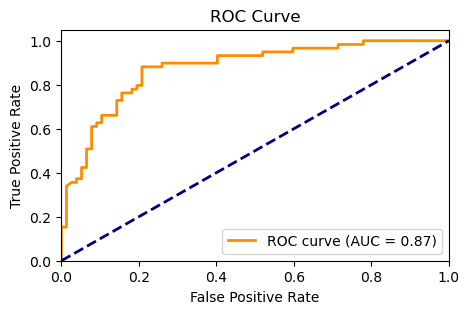

In [30]:
# ROC Curve
plt.figure(figsize=(5, 3))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
